In [1]:
from PIL import Image

%cd ./Meat_Cut/

im = Image.open('1/camera-screenshot202200011500284057.jpg')
width, height = im.size
print(width, height)
%cd ..

/Users/mzs0153/Library/CloudStorage/Box-Box/Meat Classification/Meat_Cut
1600 1200
/Users/mzs0153/Library/CloudStorage/Box-Box/Meat Classification


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

Found 8210 files belonging to 5 classes.
Using 5747 files for training.
Found 8210 files belonging to 5 classes.
Using 2463 files for validation.
Batches for testing --> tf.Tensor(30, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(47, shape=(), dtype=int64)
(32, 150, 150, 3)
(32,)


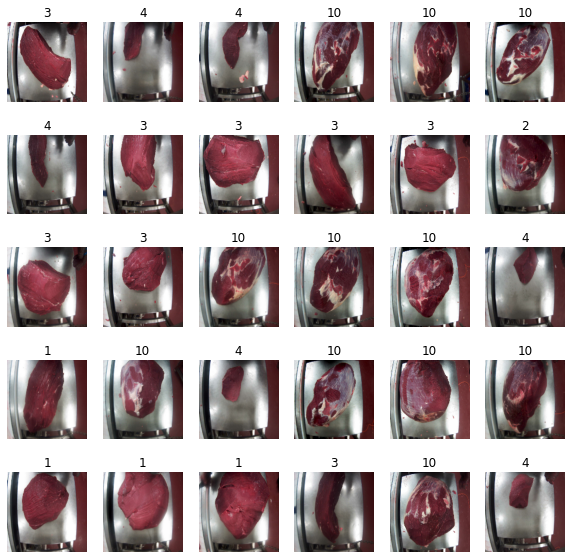

In [11]:
image_height = 150
image_width = 150
batch_size = 32

data_train= tf.keras.preprocessing.image_dataset_from_directory(
    'Meat_Cut',
    labels='inferred',
    label_mode = "int",
    class_names = ['1', '2', '3', '4', '10'],
    color_mode= 'rgb',
    batch_size=batch_size,
    image_size= (image_height, image_width),
    shuffle = True,
    seed = 123,
    validation_split = 0.30,
    subset = "training",
)


#data_train, info = tfds.load("horses_or_humans", with_info=True, split='train[:80%]')

data_valid = tf.keras.preprocessing.image_dataset_from_directory(
    'Meat_Cut',
    labels='inferred',
    label_mode = "int",
    class_names = ['1', '2', '3', '4', '10'],
    color_mode= 'rgb',
    batch_size=batch_size,
    image_size= (image_height, image_width),
    shuffle = True,
    seed = 123,
    validation_split = 0.30,
    subset = "validation",
)

data_test = data_valid.take(30)
data_valid = data_valid.skip(30)

print('Batches for testing -->', data_test.cardinality())
print('Batches for validating -->', data_valid.cardinality())

class_names = data_train.class_names

for image_batch, labels_batch in data_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

plt.figure(figsize=(10, 10))
for images, labels in data_train.take(1):
  for i in range(30):
    ax = plt.subplot(5, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [26]:
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [15]:
base_model=keras.applications.ResNet50(
    weights="imagenet",
    input_shape=(image_height,image_width,3),
    include_top=False,
)

base_model.trainable=False

inputs = keras.Input(shape=(image_height, image_width, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs=layers.Dense(5, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 10245     
                                                           

In [17]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

epochs = 3
model.fit(data_train, epochs=epochs, validation_data=data_valid)

Epoch 1/3
180/180 [==============================] - 291s 2s/step - loss: 0.4841 - accuracy: 0.8260 - val_loss: 0.2268 - val_accuracy: 0.9268
Epoch 2/3
180/180 [==============================] - 306s 2s/step - loss: 0.2537 - accuracy: 0.9120 - val_loss: 0.1845 - val_accuracy: 0.9448
Epoch 3/3
180/180 [==============================] - 298s 2s/step - loss: 0.2147 - accuracy: 0.9280 - val_loss: 0.1769 - val_accuracy: 0.9501


In [18]:
predictions = model.predict(data_test)
predictions

array([[1.3187411e-01, 1.1481857e-03, 8.6295253e-01, 1.7402136e-04,
        3.8511632e-03],
       [8.8788336e-05, 6.4200796e-03, 4.0096369e-05, 5.1773950e-06,
        9.9344581e-01],
       [1.9720771e-06, 1.4802425e-04, 5.5564101e-06, 9.2694691e-10,
        9.9984443e-01],
       ...,
       [2.8292991e-03, 2.4259221e-05, 2.5791663e-03, 9.9387807e-01,
        6.8916276e-04],
       [4.4526914e-03, 3.1917472e-05, 8.7380270e-03, 9.8475838e-01,
        2.0190028e-03],
       [3.7011440e-04, 5.9575759e-06, 1.4308521e-04, 9.9915600e-01,
        3.2480393e-04]], dtype=float32)

In [19]:
# Evaluate the best model with testing data.
print(model.evaluate(x=data_test))

30/30 [==============================] - 40s 1s/step - loss: 0.1545 - accuracy: 0.9583
[0.15450532734394073, 0.9583333134651184]


In [23]:
# we start by unfreezing all layers of the base model
base_model.trainable = True

# Freeze all layers except the 10 last layers 
for layer in base_model.layers[:-10]: 
    layer.trainable = False

# compile and retrain with a low learning rate
low_lr = 10e-5
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=low_lr),loss="sparse_categorical_crossentropy",metrics=["accuracy"])

epochs = 2
model.fit(data_train, epochs=epochs, validation_data=data_valid)

Epoch 1/2
180/180 [==============================] - 366s 2s/step - loss: 0.2064 - accuracy: 0.9401 - val_loss: 0.1474 - val_accuracy: 0.9541
Epoch 2/2
180/180 [==============================] - 334s 2s/step - loss: 0.1579 - accuracy: 0.9572 - val_loss: 0.1360 - val_accuracy: 0.9641


In [24]:
# Evaluate the model with testing data after fine tuning
print(model.evaluate(x=data_test))

30/30 [==============================] - 39s 1s/step - loss: 0.1139 - accuracy: 0.9677
[0.11389429122209549, 0.9677083492279053]
